In [1]:
# Use the same features defined for other models 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("archive/Stocks/aapl.us.txt")
df = df.iloc[:,:-1]

df['MA_Open_5'] = df['Open'].rolling(5).mean()
df['MA_Close_5'] = df['Close'].rolling(5).mean()
df['MA_Volume_5'] = df['Volume'].rolling(5).mean()

delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df['RSI_14'] = 100 - (100 / (1 + rs))

tp = (df['High'] + df['Low'] + df['Close']) / 3
ma = tp.rolling(20).mean()
dev = (tp - ma).abs().rolling(20).mean()
cci = (tp - ma) / (0.015 * dev)
df['CCI_20'] = cci

df['EMA_Close_10'] = df['Close'].ewm(span=10, adjust=False).mean()

sma = df['Close'].rolling(20).mean()
std = df['Close'].rolling(20).std()
df['BB_upper_20'] = sma + 2 * std
df['BB_lower_20'] = sma - 2 * std

df[df.columns.difference(['Date'])] = df[df.columns.difference(['Date'])].apply(lambda x: x.fillna(x.mean()))

In [2]:
# Will implement Support Vector Machine through sklearn library
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
import datetime as dt
from sklearn.preprocessing import StandardScaler

df['Date'] = pd.to_datetime(df['Date'])


cutoff_date = pd.to_datetime('2017-01-01')
train = df[df['Date'] < cutoff_date]
test = df[df['Date'] >= cutoff_date]

# Split the training and test sets into features and target
X_train = train.drop(['Date', 'Close'], axis=1)
y_train = train['Close']
X_test = test.drop(['Date', 'Close'], axis=1)
y_test = test['Close']

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# Basic Model
svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
# Train the model 
svr.fit(X_train, y_train)
y_pred = svr.predict(X_test)
display(y_pred)

array([ 2.11349139e+01,  2.15041963e+01,  2.08767873e+01,  1.77859776e+01,
        1.53399944e+01,  1.58047263e+01,  1.35345720e+01,  1.32917392e+01,
        1.25805315e+01,  1.16477088e+01,  1.10956726e+01,  1.12208817e+01,
        9.23463665e+00,  1.08506225e+01,  1.09801388e+01,  7.13125044e+00,
        5.78232304e+00,  6.42169948e+00,  5.25138324e+00,  3.82235431e+00,
        1.29164883e+01, -7.83767761e-01, -3.84852667e-02, -2.76695823e+00,
       -6.34837828e+00, -8.17125237e+00, -8.68932588e+00, -7.77005205e+00,
       -7.90357339e+00, -7.43938536e+00, -6.26536258e+00, -5.91546879e+00,
       -5.83284971e+00, -4.89167800e+00, -4.48970477e+00, -4.30184459e+00,
       -5.78242726e+00, -5.00404534e+00, -5.21727414e+00, -1.86184028e+00,
       -1.27643657e+00, -1.48189761e+00, -1.47190491e+00, -8.26732765e-01,
       -1.02974242e+00, -3.36644208e+00, -1.49772553e+00, -1.07233838e+00,
       -7.09652432e-01,  7.88710296e-01,  2.08612996e+00,  1.42503642e+00,
        3.06217727e+00,  

MSE: 14555.078928448034
MAE: 119.98596820873401
RMSE: 120.64443181700527


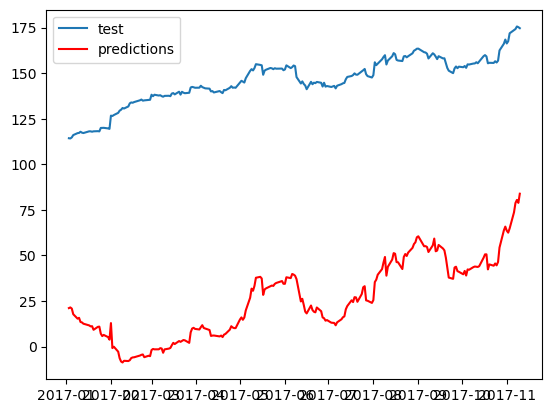

In [3]:
from math import sqrt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from matplotlib import pyplot


# evaluate forecasts
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
# plot forecasts against actual outcomes
dates = df[df['Date'] >= cutoff_date]['Date']
pyplot.plot(dates, y_test, label='test')
pyplot.plot(dates, y_pred, color='red', label = 'predictions')
pyplot.legend(loc="upper left")
# plt.xlabel("")
# plt.ylabel("")

pyplot.show()

In [6]:
# Grid search to find better parameters
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.001, 0.01,0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVR(), param_grid, refit = True, verbose = 3)
  
# fitting the model for grid search
grid.fit(X_train, y_train)

# print best parameter after tuning
print(grid.best_params_)
  
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


grid_predictions = grid.predict(X_test)
  
mse = mean_squared_error(y_test, grid_predictions)
mae = mean_absolute_error(grid_predictions, y_test)
rmse = np.sqrt(mse)
print(f'Best RMSE: {rmse}')

Fitting 5 folds for each of 35 candidates, totalling 175 fits
[CV 1/5] END ....C=0.001, gamma=1, kernel=rbf;, score=-15.891 total time=   2.9s
[CV 2/5] END ....C=0.001, gamma=1, kernel=rbf;, score=-11.795 total time=   2.9s
[CV 3/5] END .....C=0.001, gamma=1, kernel=rbf;, score=-0.638 total time=   2.9s
[CV 4/5] END .....C=0.001, gamma=1, kernel=rbf;, score=-1.897 total time=   2.6s
[CV 5/5] END .....C=0.001, gamma=1, kernel=rbf;, score=-8.408 total time=   2.3s
[CV 1/5] END ..C=0.001, gamma=0.1, kernel=rbf;, score=-12.139 total time=   2.7s
[CV 2/5] END ...C=0.001, gamma=0.1, kernel=rbf;, score=-8.951 total time=   2.6s
[CV 3/5] END ...C=0.001, gamma=0.1, kernel=rbf;, score=-0.957 total time=   2.6s
[CV 4/5] END ...C=0.001, gamma=0.1, kernel=rbf;, score=-1.762 total time=   2.3s
[CV 5/5] END ...C=0.001, gamma=0.1, kernel=rbf;, score=-8.352 total time=   2.4s
[CV 1/5] END .C=0.001, gamma=0.01, kernel=rbf;, score=-18.887 total time=   2.7s
[CV 2/5] END .C=0.001, gamma=0.01, kernel=rbf;,

[CV 2/5] END .......C=10, gamma=1, kernel=rbf;, score=-13.276 total time=   5.3s
[CV 3/5] END .......C=10, gamma=1, kernel=rbf;, score=-23.272 total time=   5.1s
[CV 4/5] END ........C=10, gamma=1, kernel=rbf;, score=-1.361 total time=   4.1s
[CV 5/5] END ........C=10, gamma=1, kernel=rbf;, score=-6.697 total time=   2.5s
[CV 1/5] END ......C=10, gamma=0.1, kernel=rbf;, score=-3.204 total time=   1.8s
[CV 2/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.762 total time=   1.9s
[CV 3/5] END ......C=10, gamma=0.1, kernel=rbf;, score=-2.977 total time=   1.8s
[CV 4/5] END .......C=10, gamma=0.1, kernel=rbf;, score=0.970 total time=   1.2s
[CV 5/5] END ......C=10, gamma=0.1, kernel=rbf;, score=-5.634 total time=   0.9s
[CV 1/5] END .....C=10, gamma=0.01, kernel=rbf;, score=-1.364 total time=   1.3s
[CV 2/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.980 total time=   1.2s
[CV 3/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.168 total time=   1.2s
[CV 4/5] END ......C=10, gam

MSE: 16482.242288518493
MAE: 127.03784299420629
RMSE: 128.3831853807908


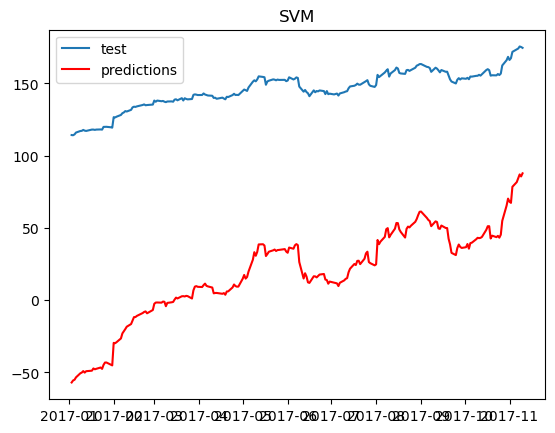

array([-56.91892888, -55.52400583, -55.02858522, -53.37698377,
       -50.55225089, -50.0693083 , -49.03074223, -50.08812274,
       -49.11662496, -48.75527993, -47.21184755, -47.78792158,
       -47.45679744, -46.55751426, -47.49777998, -44.74086787,
       -43.12237293, -43.09363302, -44.56696013, -45.08560794,
       -29.49840448, -29.75999257, -29.00422918, -26.44996992,
       -22.9613628 , -21.52352653, -19.97132393, -18.32982726,
       -16.48314558, -14.16841777, -11.69826706, -11.64292226,
       -10.83976047,  -8.86626178,  -8.10034075,  -7.74035654,
        -9.04388737,  -7.3751217 ,  -6.7759915 ,  -2.47110865,
        -1.62533721,  -1.55505754,  -1.68166158,  -0.91882768,
        -1.08524883,  -4.13250591,  -1.84700226,  -1.41899453,
        -1.19457569,   0.4570995 ,   1.80525799,   1.22999368,
         2.73135917,   2.82002931,   2.60069879,   3.02356301,
         2.8388083 ,   1.19359226,   6.85946246,   9.41949515,
         9.76270176,   9.28142828,   9.14172005,  10.45

In [9]:
# evaluate forecasts
mae = mean_absolute_error(y_test, grid_predictions)
mse = mean_squared_error(y_test, grid_predictions)
rmse = sqrt(mse)
print(f'MSE: {mse}')
print(f'MAE: {mae}')
print(f'RMSE: {rmse}')
# plot forecasts against actual outcomes
dates = df[df['Date'] >= cutoff_date]['Date']
pyplot.plot(dates, y_test, label='test')
pyplot.plot(dates, grid_predictions, color='red', label = 'predictions')
pyplot.legend(loc="upper left")
pyplot.title("SVM")
# plt.xlabel("")
# plt.ylabel("")

pyplot.show()
display(grid_predictions)